# Pre-processing the data
This notebook will demonstrate transforming the data extracted from MASS into a tabular dataset (alomst) ready for use in machine learning. This notebook will do this for one forecast reference time and one realisation, to make the development process easier (and able to run on a smaller compute instance), and then a separate notebook will be created to do the actual "batch" processing of data.

We are using data around Storm Dennis ([Met Office](https://www.metoffice.gov.uk/weather/warnings-and-advice/uk-storm-centre/storm-dennis), [Wikipedia](https://en.wikipedia.org/wiki/Storm_Dennis))

The key steps in this process are as follows:
* Prepare radar data
  * Load in radar data files extracted from mass and agggregated into 1 file per day of data 
  * Accumuluate in 3hr accumulations to match 3 hour frequency of model data
  * Load a sample MOGREPS-UK UK cutout grid to use a regridding target
  * regrid radar data
  * transform into tabular data
* Prepare MOGREPS-G data
  * Load in data extract from MASS for the forecast reference times and leadtime of interest (IN this case around Storm Dennis 15/16 Feb 2020)
  * Extract UK Data
  * For each forecast ref time,load in all single level variables and transform to tabular (using xarray.Dataset.to_dataframe)
  * For each forecast ref time, load in variables on height levels and tranform to data frame
  * the xarray function by default puts variables on different heights on different rows, whereas we want all levels of a variable for a particular time/lat/lon/realization to be on the same row as separate features/columns. Transform by selecting different heights, renaming variables to include name and height, and merging together.
  * merge single level and height levels variables
  * concatenate different times into a single dataframe and save to disk.

In [1]:
import pathlib
import datetime
import functools
import os

In [2]:
import numpy

In [3]:
import pandas

In [111]:
import xarray
import iris
import iris.quickplot
import iris.coord_categorisation

In [5]:
import matplotlib.pyplot

# Set parameters for notebook
Set the paths and lists of things to process

In [6]:
project_name = 'precip_rediagnosis'
mogreps_g_name = 'mogreps-g'
ilab_project_dir = pathlib.Path('/project/informatics_lab/')
output_dir =  pathlib.Path('/scratch')/ os.environ['USER'] / project_name

In [7]:
root_data_dir = ilab_project_dir / project_name
mogreps_g_data_dir = root_data_dir / mogreps_g_name
radar_data_dir = root_data_dir / 'radar'

In [8]:
output_fname_template = 'prd_{lt:03d}H_{vt.year:04d}{vt.month:02d}{vt.day:02d}T{vt.hour:02d}{vt.minute:02d}Z.csv'

In [9]:
variables_single_level = [
    "cloud_amount_of_total_cloud",
    "rainfall_accumulation-PT03H",
    "snowfall_accumulation-PT03H",
    "rainfall_rate",
    "snowfall_rate",
    "height_of_orography",
    "pressure_at_mean_sea_level",
]

variables_height_levels = [
    "cloud_amount_on_height_levels",
    "pressure_on_height_levels",
    "temperature_on_height_levels",
    "relative_humidity_on_height_levels",
    "wind_direction_on_height_levels",
    "wind_speed_on_height_levels",
    
]

In [10]:
num_periods = 10
start_ref_time = datetime.datetime(2020,2,14,12)
forecast_ref_time_range = [start_ref_time + datetime.timedelta(hours=6)*i1 for i1 in range(num_periods)]
leadtime_hours = 15
realizations_list = list(range(35))

In [11]:
dataset = 'mogreps-g'
subset = 'lev1'
forecast_ref_template = '{frt.year:04d}{frt.month:02d}{frt.day:02d}T{frt.hour:02d}00Z.nc.file'
fname_template = '{vt.year:04d}{vt.month:02d}{vt.day:02d}T{vt.hour:02d}00Z-PT{lead_time:04d}H00M-{var_name}.nc'

In [12]:
variables_to_extract = variables_height_levels + variables_single_level

In [13]:
path_lists_vars = {
    var_name: [f1 for f1 in mogreps_g_data_dir.iterdir() if var_name in str(f1)]
    for var_name in variables_to_extract
}


In [29]:
uk_bounds={'latitude':(50,58), 'longitude': (-6,2)}
xarray_select_uk = {k1: slice(*v1) for k1,v1 in uk_bounds.items()}

## Create a dataset from MOGREPS-G data
Information on Met Office Ensmble forecasts - https://www.metoffice.gov.uk/research/weather/ensemble-forecasting#
Paper - https://www.metoffice.gov.uk/research/weather/ensemble-forecasting 

In [15]:
fcst_ref_time = forecast_ref_time_range[0]
real1 = realizations_list[10]
validity_time = fcst_ref_time + datetime.timedelta(hours=leadtime_hours)

The file names do not match the variables names within the files, so we need to create a mapping to work with.

In [16]:
%%time
# load a cube for each variable in iris to get the actual variable name, and populate dictionary mapping from the var name in the file name to the variable as loaded into iris/xarray
file_to_var_mapping = {
    var_file_name: iris.load_cube(str(mogreps_g_data_dir / fname_template.format(vt=validity_time,
                                                                                 lead_time=leadtime_hours,
                                                                                 var_name=var_file_name))).name()
    for var_file_name in variables_single_level + variables_height_levels}
file_to_var_mapping

CPU times: user 750 ms, sys: 91.6 ms, total: 842 ms
Wall time: 2 s


{'cloud_amount_of_total_cloud': 'cloud_area_fraction',
 'rainfall_accumulation-PT03H': 'thickness_of_rainfall_amount',
 'snowfall_accumulation-PT03H': 'lwe_thickness_of_snowfall_amount',
 'rainfall_rate': 'rainfall_rate',
 'snowfall_rate': 'lwe_snowfall_rate',
 'height_of_orography': 'surface_altitude',
 'pressure_at_mean_sea_level': 'air_pressure_at_sea_level',
 'cloud_amount_on_height_levels': 'cloud_volume_fraction_in_atmosphere_layer',
 'pressure_on_height_levels': 'air_pressure',
 'temperature_on_height_levels': 'air_temperature',
 'relative_humidity_on_height_levels': 'relative_humidity',
 'wind_direction_on_height_levels': 'wind_from_direction',
 'wind_speed_on_height_levels': 'wind_speed'}

In [17]:
single_level_var_mappings = {v1: file_to_var_mapping[v1] for v1 in variables_single_level}
height_level_var_mappings = {v1: file_to_var_mapping[v1] for v1 in variables_height_levels}

In [18]:
for fcst_ref_time in forecast_ref_time_range:
    print(fcst_ref_time)

2020-02-14 12:00:00
2020-02-14 18:00:00
2020-02-15 00:00:00
2020-02-15 06:00:00
2020-02-15 12:00:00
2020-02-15 18:00:00
2020-02-16 00:00:00
2020-02-16 06:00:00
2020-02-16 12:00:00
2020-02-16 18:00:00


Create a function to load the data for a particular location (because this project is interested in the UK) and realization (to keep data manageable during development).

In [50]:
def load_realization_ds(ds_path, realization, selected_bounds):
    try:
        subset1 = dict(selected_bounds)
        subset1['realization'] = realization
        subset1['bnds'] = 0
        single_level_ds = xarray.load_dataset(ds_path).sel(**subset1)
    except KeyError as e1:
        single_level_ds = None
    return single_level_ds

In [51]:
%%time
ds_list = [load_realization_ds(
    ds_path= mogreps_g_data_dir / fname_template.format(vt=validity_time,
                                                     lead_time=leadtime_hours,
                                                     var_name=var1),
    realization=real1,
    selected_bounds=xarray_select_uk,
)
    for var1 in variables_single_level]
single_level_ds = xarray.merge([ds1 for ds1 in ds_list if ds1 is not None])


CPU times: user 2.34 s, sys: 388 ms, total: 2.73 s
Wall time: 2.99 s


First process the single level variables.

In [52]:
%%time
single_level_df = single_level_ds.to_dataframe().reset_index()
single_level_df

CPU times: user 9.76 ms, sys: 2.13 ms, total: 11.9 ms
Wall time: 9.27 ms


,latitude,longitude,cloud_area_fraction,latitude_longitude,realization,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,thickness_of_rainfall_amount,forecast_period_bnds,time_bnds,lwe_thickness_of_snowfall_amount,rainfall_rate,lwe_snowfall_rate,surface_altitude,air_pressure_at_sea_level
0,50.15625,-5.765625,1.0000,-2147483647,10,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.000391,43200,2020-02-15,0.0,1.862645e-08,0.0,0.0000,100829.0
1,50.15625,-5.484375,1.0000,-2147483647,10,50.0625,-5.62500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.001012,43200,2020-02-15,0.0,3.818423e-08,0.0,31.9375,100878.0
2,50.15625,-5.203125,1.0000,-2147483647,10,50.0625,-5.34375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.001418,43200,2020-02-15,0.0,5.308539e-08,0.0,45.9375,100921.0
3,50.15625,-4.921875,1.0000,-2147483647,10,50.0625,-5.06250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.001164,43200,2020-02-15,0.0,3.818423e-08,0.0,0.0000,100972.0
4,50.15625,-4.640625,1.0000,-2147483647,10,50.0625,-4.78125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.001074,43200,2020-02-15,0.0,3.073364e-08,0.0,0.0000,101022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,57.84375,0.703125,0.0000,-2147483647,10,57.7500,0.56250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.000000,43200,2020-02-15,0.0,0.000000e+00,0.0,0.0000,100448.0
1172,57.84375,0.984375,0.0000,-2147483647,10,57.7500,0.84375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.000000,43200,2020-02-15,0.0,0.000000e+00,0.0,0.0000,100469.0
1173,57.84375,1.265625,0.0000,-2147483647,10,57.7500,1.12500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.000000,43200,2020-02-15,0.0,0.000000e+00,0.0,0.0000,100485.0
1174,57.84375,1.546875,0.1875,-2147483647,10,57.7500,1.40625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,0.000000,43200,2020-02-15,0.0,0.000000e+00,0.0,0.0000,100498.0


Load the variables on height levels and create a data frame using the xarray `to_dataframe` function.

In [53]:
%%time
ds_list1 = [load_realization_ds(
    ds_path=mogreps_g_data_dir / fname_template.format(vt=validity_time,
                                                       lead_time=leadtime_hours,
                                                       var_name=var1),
    realization=real1,
    selected_bounds=xarray_select_uk,
)
            for var1 in variables_height_levels]


CPU times: user 2min 19s, sys: 12.7 s, total: 2min 32s
Wall time: 3min 26s


In [54]:
height_levels_ds =  xarray.merge([ds1 for ds1 in ds_list1 if ds1 is not None])

In [71]:
%%time
hl_df_multirow = height_levels_ds.to_dataframe().reset_index()

CPU times: user 16.1 ms, sys: 1.21 ms, total: 17.3 ms
Wall time: 14.6 ms


In [73]:
hl_df_multirow

,height,latitude,longitude,cloud_volume_fraction_in_atmosphere_layer,latitude_longitude,realization,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,air_pressure,air_temperature,relative_humidity,wind_from_direction,wind_speed
0,5.0,50.15625,-5.765625,0.0,-2147483647,10,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,100769.3750,284.1250,1.004883,200.8125,11.7500
1,5.0,50.15625,-5.484375,0.0,-2147483647,10,50.0625,-5.62500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,100436.2500,284.1875,1.007812,203.6250,10.4375
2,5.0,50.15625,-5.203125,0.0,-2147483647,10,50.0625,-5.34375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,100312.9375,284.1875,1.001953,206.8750,10.3750
3,5.0,50.15625,-4.921875,0.0,-2147483647,10,50.0625,-5.06250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,100912.5000,284.3125,0.977539,207.7500,11.9375
4,5.0,50.15625,-4.640625,0.0,-2147483647,10,50.0625,-4.78125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,100962.4375,284.1875,0.977539,208.3750,12.3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38803,6000.0,57.84375,0.703125,0.0,-2147483647,10,57.7500,0.56250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,45534.8750,239.4375,0.164062,264.6250,37.1875
38804,6000.0,57.84375,0.984375,0.0,-2147483647,10,57.7500,0.84375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,45545.5000,239.0625,0.198242,262.0625,34.7500
38805,6000.0,57.84375,1.265625,0.0,-2147483647,10,57.7500,1.12500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,45557.0625,238.9375,0.234375,258.7500,32.5000
38806,6000.0,57.84375,1.546875,0.0,-2147483647,10,57.7500,1.40625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,45569.0000,238.8125,0.276367,255.3750,31.0625


As shown above, the xarray method puts variables at different heights in different rows, where really we want them in the same row in separate columns e.g. `air_temperature_5m`, `air_temperature_10m` etc. So here we select each of the heights in turn and merge the resulting data frames to get what we want.

In [74]:
heights = hl_df_multirow['height'].unique()

In [75]:
print('\n'.join([f'{h1:.2f}m' for h1 in heights]))

5.00m
10.00m
20.00m
30.00m
50.00m
75.00m
100.00m
150.00m
200.00m
250.00m
300.00m
400.00m
500.00m
600.00m
700.00m
800.00m
1000.00m
1250.00m
1500.00m
1750.00m
2000.00m
2250.00m
2500.00m
2750.00m
3000.00m
3250.00m
3500.00m
3750.00m
4000.00m
4500.00m
5000.00m
5500.00m
6000.00m


In [62]:
merge_coords = ['latitude', 'longitude', 'time', 'realization']

In [76]:
coords = list(set(hl_df_multirow.columns) - set(height_level_var_mappings.values()))
print(coords)

['forecast_period', 'longitude', 'height', 'realization', 'time', 'latitude', 'latitude_longitude', 'forecast_reference_time', 'longitude_bnds', 'latitude_bnds']


In [80]:
%%time
var_df_merged = []
# heights_vars_marged = height_levels_df[height_levels_df.height==heights[0]][ merge_coords]
for var1 in height_level_var_mappings.values():
    print(var1)
    # for h1 in heights:
    #     heights_vars_marged[f'{var1}_{h1:.1f}'] = list(height_levels_df[height_levels_df.height==h1][var1])
    var_at_heights = [hl_df_multirow[hl_df_multirow.height==h1][merge_coords + [var1]].rename({var1: f'{var1}_{h1:.1f}'}, axis='columns') for h1 in heights]
    var_df_merged += [functools.reduce(lambda x,y: x.merge(y, on=merge_coords), var_at_heights)]
height_levels_df = functools.reduce(lambda x,y: x.merge(y, on=merge_coords), var_df_merged)

cloud_volume_fraction_in_atmosphere_layer
air_pressure
air_temperature
relative_humidity
wind_from_direction
wind_speed
CPU times: user 1.37 s, sys: 3.14 ms, total: 1.38 s
Wall time: 1.37 s


In [82]:
height_levels_df

,latitude,longitude,time,realization,cloud_volume_fraction_in_atmosphere_layer_5.0,cloud_volume_fraction_in_atmosphere_layer_10.0,cloud_volume_fraction_in_atmosphere_layer_20.0,cloud_volume_fraction_in_atmosphere_layer_30.0,cloud_volume_fraction_in_atmosphere_layer_50.0,cloud_volume_fraction_in_atmosphere_layer_75.0,...,wind_speed_2750.0,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0
0,50.15625,-5.765625,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.179688,...,32.1875,31.3125,30.2500,29.6250,29.4375,29.3750,31.3750,38.0000,37.5625,34.6250
1,50.15625,-5.484375,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.117188,...,31.2500,31.1250,30.5625,29.8125,29.1875,28.8750,29.5000,36.3750,37.5625,35.6875
2,50.15625,-5.203125,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.101562,...,30.1875,30.3750,30.3125,29.7500,28.9375,28.3125,28.8750,34.1875,36.3750,36.0000
3,50.15625,-4.921875,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.039062,...,29.3125,29.5000,29.6875,29.3750,28.6875,27.8750,28.6250,32.1250,35.1250,35.8750
4,50.15625,-4.640625,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.000000,...,28.7500,28.9375,29.1875,29.0625,28.5625,27.8750,28.4375,31.0000,33.8750,35.3125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,57.84375,0.703125,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.000000,...,12.6875,12.5000,12.8125,13.6875,15.3750,18.3750,22.0625,25.6875,29.3125,37.1875
1172,57.84375,0.984375,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.000000,...,12.8125,12.4375,12.6875,13.4375,15.0625,18.0625,22.6250,25.7500,28.8125,34.7500
1173,57.84375,1.265625,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.000000,...,13.3750,12.8125,12.9375,13.5625,14.9375,17.6250,23.0625,25.7500,28.7500,32.5000
1174,57.84375,1.546875,2020-02-15 03:00:00,10,0.0,0.0,0.0,0.0,0.0,0.000000,...,14.5000,13.7500,13.7500,14.2500,15.4375,17.3750,23.4375,25.8750,28.8750,31.0625


Now that we have created the correct dataframe for variables on height levels, we can merge this with the dataframe for single level variables. We are merging on the following coordinates:
* location (latitude and longitude)
* time (validity time)
* realization

In [84]:
mogreps_g_single_ts_uk_df = single_level_df.merge(height_levels_df, on=merge_coords)
mogreps_g_single_ts_uk_df

,latitude,longitude,cloud_area_fraction,latitude_longitude,realization,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,...,wind_speed_2750.0,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0
0,50.15625,-5.765625,1.0000,-2147483647,10,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,32.1875,31.3125,30.2500,29.6250,29.4375,29.3750,31.3750,38.0000,37.5625,34.6250
1,50.15625,-5.484375,1.0000,-2147483647,10,50.0625,-5.62500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,31.2500,31.1250,30.5625,29.8125,29.1875,28.8750,29.5000,36.3750,37.5625,35.6875
2,50.15625,-5.203125,1.0000,-2147483647,10,50.0625,-5.34375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,30.1875,30.3750,30.3125,29.7500,28.9375,28.3125,28.8750,34.1875,36.3750,36.0000
3,50.15625,-4.921875,1.0000,-2147483647,10,50.0625,-5.06250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,29.3125,29.5000,29.6875,29.3750,28.6875,27.8750,28.6250,32.1250,35.1250,35.8750
4,50.15625,-4.640625,1.0000,-2147483647,10,50.0625,-4.78125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,28.7500,28.9375,29.1875,29.0625,28.5625,27.8750,28.4375,31.0000,33.8750,35.3125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,57.84375,0.703125,0.0000,-2147483647,10,57.7500,0.56250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,12.6875,12.5000,12.8125,13.6875,15.3750,18.3750,22.0625,25.6875,29.3125,37.1875
1172,57.84375,0.984375,0.0000,-2147483647,10,57.7500,0.84375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,12.8125,12.4375,12.6875,13.4375,15.0625,18.0625,22.6250,25.7500,28.8125,34.7500
1173,57.84375,1.265625,0.0000,-2147483647,10,57.7500,1.12500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,13.3750,12.8125,12.9375,13.5625,14.9375,17.6250,23.0625,25.7500,28.7500,32.5000
1174,57.84375,1.546875,0.1875,-2147483647,10,57.7500,1.40625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,14.5000,13.7500,13.7500,14.2500,15.4375,17.3750,23.4375,25.8750,28.8750,31.0625


In [244]:
prd_single_timestep_df = single_level_df.merge(height_levels_df, on=merge_coords)

In [245]:
prd_single_timestep_df

,latitude,longitude,cloud_area_fraction,latitude_longitude,realization,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,...,wind_speed_2750.0,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0
0,50.15625,-5.765625,1.0000,-2147483647,10,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,32.1875,31.3125,30.2500,29.6250,29.4375,29.3750,31.3750,38.0000,37.5625,34.6250
1,50.15625,-5.484375,1.0000,-2147483647,10,50.0625,-5.62500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,31.2500,31.1250,30.5625,29.8125,29.1875,28.8750,29.5000,36.3750,37.5625,35.6875
2,50.15625,-5.203125,1.0000,-2147483647,10,50.0625,-5.34375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,30.1875,30.3750,30.3125,29.7500,28.9375,28.3125,28.8750,34.1875,36.3750,36.0000
3,50.15625,-4.921875,1.0000,-2147483647,10,50.0625,-5.06250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,29.3125,29.5000,29.6875,29.3750,28.6875,27.8750,28.6250,32.1250,35.1250,35.8750
4,50.15625,-4.640625,1.0000,-2147483647,10,50.0625,-4.78125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,28.7500,28.9375,29.1875,29.0625,28.5625,27.8750,28.4375,31.0000,33.8750,35.3125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,57.84375,0.703125,0.0000,-2147483647,10,57.7500,0.56250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,12.6875,12.5000,12.8125,13.6875,15.3750,18.3750,22.0625,25.6875,29.3125,37.1875
1172,57.84375,0.984375,0.0000,-2147483647,10,57.7500,0.84375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,12.8125,12.4375,12.6875,13.4375,15.0625,18.0625,22.6250,25.7500,28.8125,34.7500
1173,57.84375,1.265625,0.0000,-2147483647,10,57.7500,1.12500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,13.3750,12.8125,12.9375,13.5625,14.9375,17.6250,23.0625,25.7500,28.7500,32.5000
1174,57.84375,1.546875,0.1875,-2147483647,10,57.7500,1.40625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,14.5000,13.7500,13.7500,14.2500,15.4375,17.3750,23.4375,25.8750,28.8750,31.0625


### Load radar data

Now we want to load the radar, to add a radar rainfall measurement to each column.

In [97]:
radar_days = [datetime.datetime(2020,2,14) + datetime.timedelta(days=d1) for d1 in range(5)]
radar_days

[datetime.datetime(2020, 2, 14, 0, 0),
 datetime.datetime(2020, 2, 15, 0, 0),
 datetime.datetime(2020, 2, 16, 0, 0),
 datetime.datetime(2020, 2, 17, 0, 0),
 datetime.datetime(2020, 2, 18, 0, 0)]

In [98]:
radar_fname_template = 'composite_rainfall_{dt.year:04d}{dt.month:02d}{dt.day:02d}.nc'

Create a single cube of all the radar for the period concerned that has been extract from MASS.
(See `extract_mass_radar.py` for details.)

In [121]:
radar_cube = iris.cube.CubeList([iris.load_cube(str(radar_data_dir / radar_fname_template.format(dt=dt1))) for dt1 in radar_days] ).concatenate_cube()

In [136]:
radar_cube

Rainfall Rate Composite (mm/h),time,projection_y_coordinate,projection_x_coordinate
Shape,1440,2175,1725
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
day_of_year,x,-,-
forecast_reference_time,x,-,-
hour,x,-,-
Scalar coordinates,,,forecast_period 0 second


In [132]:
min([datetime.datetime(c1.point.year, c1.point.month, c1.point.day, c1.point.hour, c1.point.minute) for c1 in radar_cube.coord('time').cells()])

datetime.datetime(2020, 2, 14, 0, 0)

Radar data is instantaeous rainfall rates, measured every 5 minutes. Model data is every three hours. TO match these together, we will calculate "pseudo-accumulations" (pseudo because we're assuming that the instaneous rate represents 5 minute accumulations if we divide by 12, but the rain rate will not be constant in a 5 minute period.) Something we could consider would be some better statistical model to interpolate and do better accumulation calculations, but this is a starting point.

In [135]:
iris.coord_categorisation.add_hour(radar_cube, coord='time')
iris.coord_categorisation.add_day_of_year(radar_cube, coord='time')

In [174]:
coord_3hr = iris.coords.AuxCoord(radar_cube.coord('hour').points // 3,
                                long_name='3hr',
                                 units='hour',
                                )
radar_cube.add_aux_coord(coord_3hr, data_dims=0)

In [175]:
radar_agg = radar_cube.aggregated_by(['3hr', 'day_of_year'],iris.analysis.SUM)

In [176]:
radar_agg

Rainfall Rate Composite (mm/h),time,projection_y_coordinate,projection_x_coordinate
Shape,40,2175,1725
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
3hr,x,-,-
day_of_year,x,-,-
forecast_reference_time,x,-,-
hour,x,-,-


/tmp/ipykernel_29797/3880320989.py:1: CFWarning: year=0 was specified - this date/calendar/year zero convention is not supported by CF
  cftime.DatetimeGregorian(year=0,month=0,day=0,hour=0,minute=5)
/tmp/ipykernel_29797/3880320989.py:1: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.DatetimeGregorian(year=0,month=0,day=0,hour=0,minute=5)


ValueError: invalid month provided in cftime.DatetimeGregorian(0, 0, 0, 0, 5, 0, 0, has_year_zero=True)

In [206]:
radar_agg.add_aux_coord(iris.coords.AuxCoord([c1.bound[0] + datetime.timedelta(hours=3) for c1 in radar_agg.coord('time').cells()], long_name='model_accum_time', units='mm/h'), data_dims=0)

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


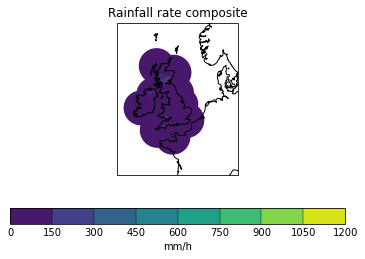

In [177]:
iris.quickplot.contourf(radar_agg [12,:,:])
matplotlib.pyplot.gca().coastlines()

Load a sample variable from MOGREPS-G to use for regridding radar data.

In [178]:
mogreps_g_example = iris.load_cube(
    str(mogreps_g_data_dir / fname_template.format(
        vt=forecast_ref_time_range[0] + datetime.timedelta(hours=leadtime_hours), 
        lead_time=leadtime_hours, 
        var_name=variables_single_level[0])),
    iris.Constraint(latitude=lambda cell1: uk_bounds['latitude'][0] < cell1 < uk_bounds['latitude'][1], 
                                                     longitude=lambda cell1: uk_bounds['longitude'][0] < cell1 < uk_bounds['longitude'][1], realization=0)
)


In [179]:
mogreps_g_example

<iris 'Cube' of cloud_area_fraction / (1) (latitude: 42; longitude: 28)>

In [208]:
radar_mggrid = radar_agg.regrid(mogreps_g_example, iris.analysis.Linear())

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


In [209]:
radar_mggrid

Rainfall Rate Composite (mm/h),time,latitude,longitude
Shape,40,42,28
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
3hr,x,-,-
day_of_year,x,-,-
forecast_reference_time,x,-,-
hour,x,-,-


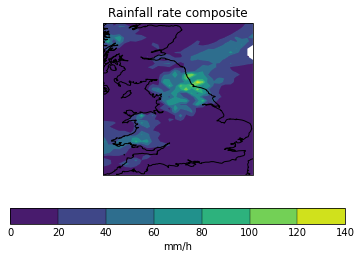

In [182]:
iris.quickplot.contourf(radar_mggrid [14,:,:])
matplotlib.pyplot.gca().coastlines()

It is slightly tortuous, but having used the useful Iris functionality, we now swiotch to xarray to use the `to_dataframe` functionality.We could probably stick to one or the other rather, and that is a potential future refactoring (if possible).

In [213]:
radar_df = xarray.DataArray.from_iris(radar_mggrid).to_dataframe().reset_index()

In [219]:
radar_df

,time,latitude,longitude,forecast_period,3hr,day_of_year,forecast_reference_time,hour,model_accum_time,rainfall_rate_composite
0,2020-02-14 01:27:30,50.15625,-5.765625,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
1,2020-02-14 01:27:30,50.15625,-5.484375,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
2,2020-02-14 01:27:30,50.15625,-5.203125,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
3,2020-02-14 01:27:30,50.15625,-4.921875,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
4,2020-02-14 01:27:30,50.15625,-4.640625,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...
47035,2020-02-18 22:27:30,57.84375,0.703125,0,7,49,2020-02-18 22:27:30,22.0,2020-02-19 00:00:00,NaN
47036,2020-02-18 22:27:30,57.84375,0.984375,0,7,49,2020-02-18 22:27:30,22.0,2020-02-19 00:00:00,NaN
47037,2020-02-18 22:27:30,57.84375,1.265625,0,7,49,2020-02-18 22:27:30,22.0,2020-02-19 00:00:00,NaN
47038,2020-02-18 22:27:30,57.84375,1.546875,0,7,49,2020-02-18 22:27:30,22.0,2020-02-19 00:00:00,NaN


In [227]:
radar_df = radar_df.rename({'time': 'period_midpoint', : 'time'}, axis='columns')
radar_df['time'] = radar_df['model_accum_time'].apply(lambda dt1: datetime.datetime(dt1.year, dt1.month, dt1.day, dt1.hour, dt1.minute))
radar_df

,period_midpoint,latitude,longitude,forecast_period,3hr,day_of_year,forecast_reference_time,hour,time,rainfall_rate_composite
0,2020-02-14 01:27:30,50.15625,-5.765625,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
1,2020-02-14 01:27:30,50.15625,-5.484375,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
2,2020-02-14 01:27:30,50.15625,-5.203125,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
3,2020-02-14 01:27:30,50.15625,-4.921875,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
4,2020-02-14 01:27:30,50.15625,-4.640625,0,0,45,2020-02-14 01:27:30,1.0,2020-02-14 03:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...
47035,2020-02-18 22:27:30,57.84375,0.703125,0,7,49,2020-02-18 22:27:30,22.0,2020-02-19 00:00:00,NaN
47036,2020-02-18 22:27:30,57.84375,0.984375,0,7,49,2020-02-18 22:27:30,22.0,2020-02-19 00:00:00,NaN
47037,2020-02-18 22:27:30,57.84375,1.265625,0,7,49,2020-02-18 22:27:30,22.0,2020-02-19 00:00:00,NaN
47038,2020-02-18 22:27:30,57.84375,1.546875,0,7,49,2020-02-18 22:27:30,22.0,2020-02-19 00:00:00,NaN


In [224]:
prd_single_timestep_df['time'][0]

Timestamp('2020-02-15 03:00:00')

In [251]:
radar_df = radar_df[['latitude', 'longitude','time','rainfall_rate_composite']]

In [146]:
single_ts_ds = xarray.merge([single_level_ds, height_levels_ds])

In [147]:
single_ts_ds.to_netcdf('/scratch/shaddad/precip_rediagnosis/mogreps_g_uk001.nc')

Now we have the radar data, we can merge with model data and save to disk.

In [252]:
prd_single_timestep_df.merge(radar_df[radar_df['time'] == prd_single_timestep_df['time'][0]], on=['latitude', 'longitude', 'time'])

,latitude,longitude,cloud_area_fraction,latitude_longitude,realization,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,...,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0,rainfall_rate_composite
0,50.15625,-5.765625,1.0000,-2147483647,10,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,31.3125,30.2500,29.6250,29.4375,29.3750,31.3750,38.0000,37.5625,34.6250,0.055013
1,50.15625,-5.484375,1.0000,-2147483647,10,50.0625,-5.62500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,31.1250,30.5625,29.8125,29.1875,28.8750,29.5000,36.3750,37.5625,35.6875,0.492275
2,50.15625,-5.203125,1.0000,-2147483647,10,50.0625,-5.34375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,30.3750,30.3125,29.7500,28.9375,28.3125,28.8750,34.1875,36.3750,36.0000,2.186998
3,50.15625,-4.921875,1.0000,-2147483647,10,50.0625,-5.06250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,29.5000,29.6875,29.3750,28.6875,27.8750,28.6250,32.1250,35.1250,35.8750,4.726730
4,50.15625,-4.640625,1.0000,-2147483647,10,50.0625,-4.78125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,28.9375,29.1875,29.0625,28.5625,27.8750,28.4375,31.0000,33.8750,35.3125,2.154922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,57.84375,0.703125,0.0000,-2147483647,10,57.7500,0.56250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,12.5000,12.8125,13.6875,15.3750,18.3750,22.0625,25.6875,29.3125,37.1875,0.000000
1172,57.84375,0.984375,0.0000,-2147483647,10,57.7500,0.84375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,12.4375,12.6875,13.4375,15.0625,18.0625,22.6250,25.7500,28.8125,34.7500,0.000000
1173,57.84375,1.265625,0.0000,-2147483647,10,57.7500,1.12500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,12.8125,12.9375,13.5625,14.9375,17.6250,23.0625,25.7500,28.7500,32.5000,0.000000
1174,57.84375,1.546875,0.1875,-2147483647,10,57.7500,1.40625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,13.7500,13.7500,14.2500,15.4375,17.3750,23.4375,25.8750,28.8750,31.0625,0.000000


# Output as daily parquet files

In [253]:
output_fname = output_fname_template.format(lt=leadtime_hours, vt=validity_time)
output_path = output_dir / output_fname
prd_single_timestep_df.to_csv(output_path)

Currently I don't have parquet set up in our environments, so just using CSV for now (this is a small data set so far).